# All required imports and setting up constants

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
SEED_CONSTANT= 42
np.random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/hmdb51'
#SELECTED_ACTIONS = ['clap', 'climb_stairs', 'drink', 'eat', 'fall_floor', 'jump', 'run', 'shake_hands', 'sit', 'stand', 'walk', 'wave']
SELECTED_ACTIONS = ['climb_stairs', 'jump', 'run', 'sit', 'stand', 'wave']

VIDEO_WIDTH= 75 # Min width is 300
VIDEO_HEIGHT= 60 # All video have same height of 240
MAX_FRAMES= 30 # Maximum of 30 frames from each video

# Visualise the data and Categories available

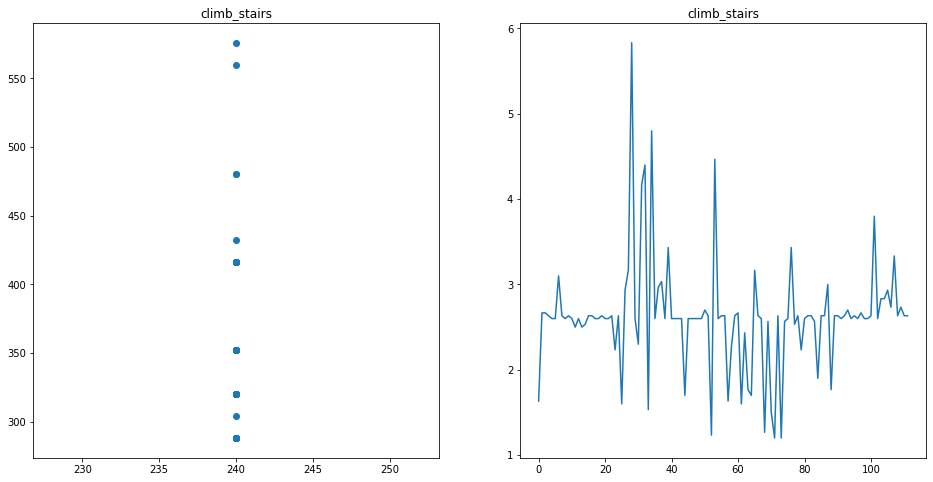

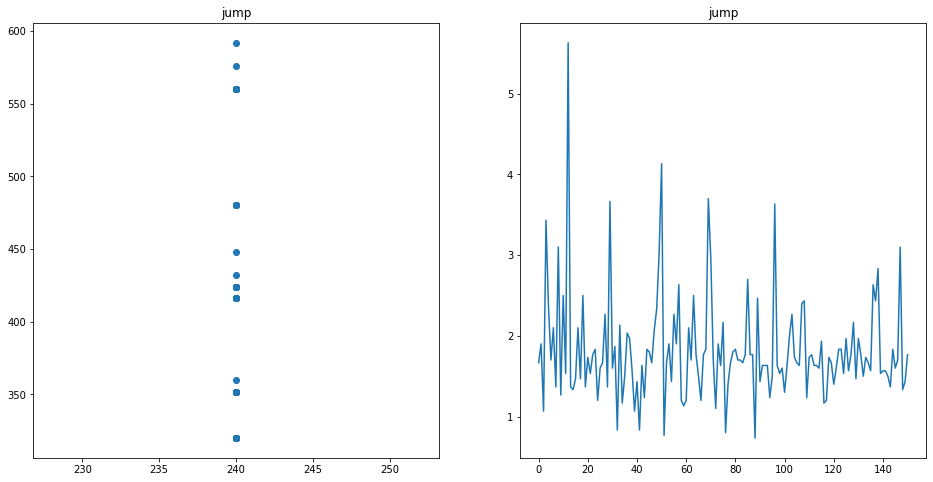

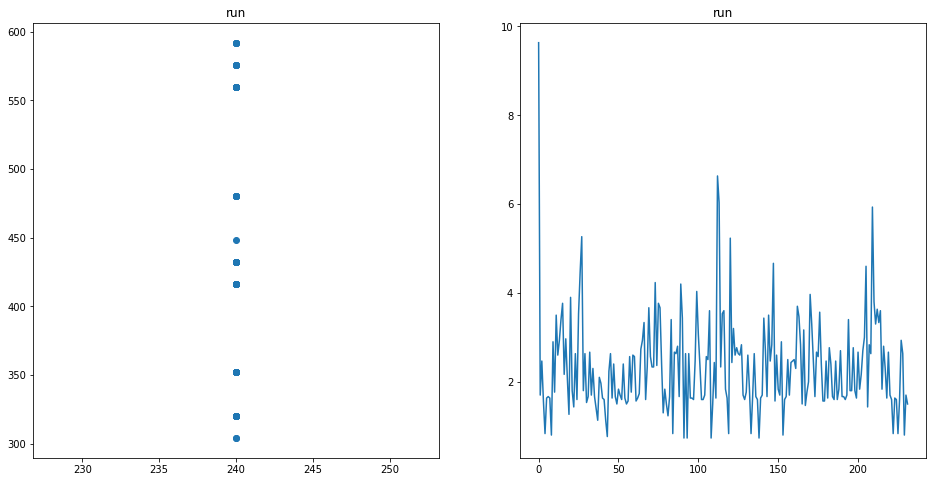

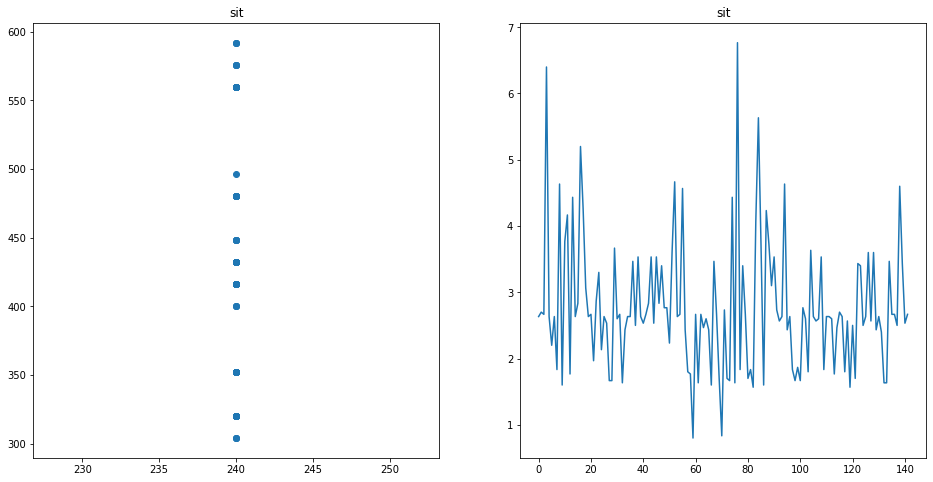

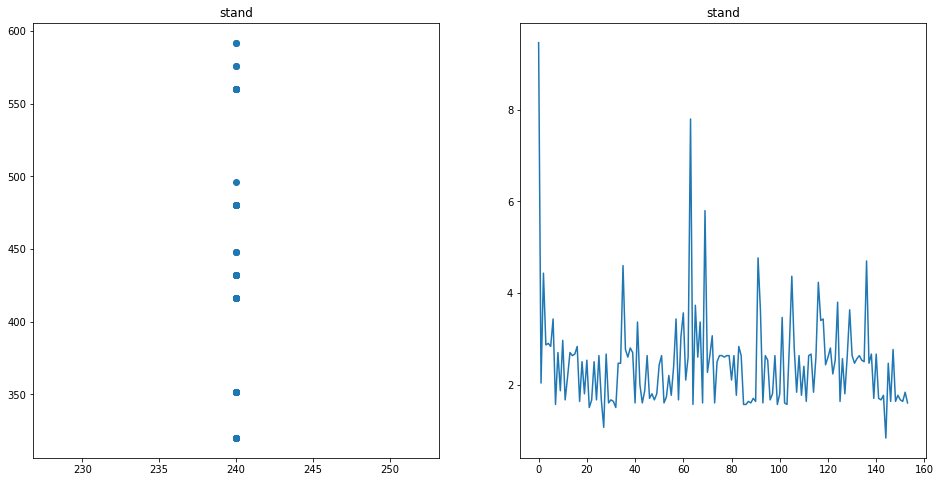

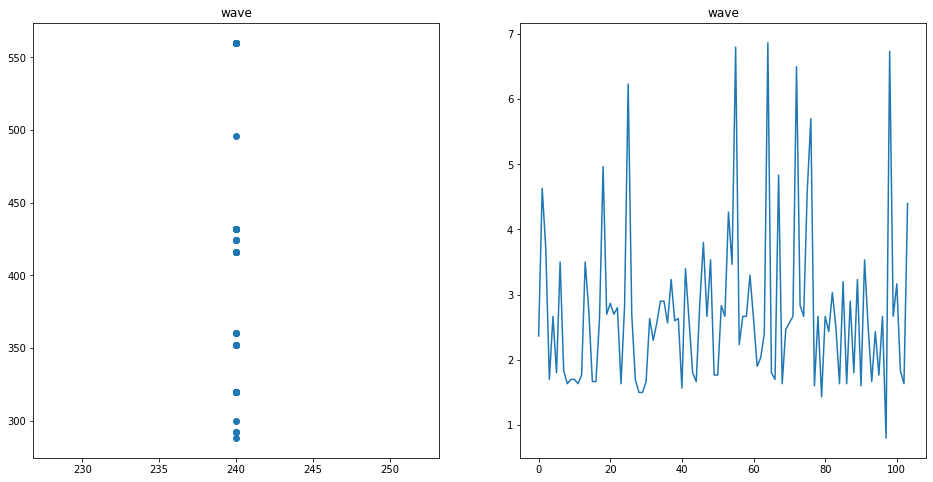

In [4]:
#plt.figure(figsize = (50, 50))
#class_names = os.listdir(DATASET_DIR)
#class_names = os.listdir('UCF-101')

for i, currentAction in enumerate(SELECTED_ACTIONS, 1):
    videos = os.listdir(f'{DATASET_DIR}/{currentAction}/{currentAction}')
    #selected_video = random.choice(videos)
    
    videoWidths= []
    videoHeights= []
    videoDurations= []
    # videoFPS= [] all videos are 30 FPS
    for vid in videos:
        cap = cv2.VideoCapture(f'{DATASET_DIR}/{currentAction}/{currentAction}/{vid}')
        videoWidths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        videoHeights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        videoDurations.append(cap.get(cv2.CAP_PROP_FRAME_COUNT)/cap.get(cv2.CAP_PROP_FPS))
        # videoFPS.append(cap.get(cv2.CAP_PROP_FPS))
        cap.release()
    
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.scatter(videoHeights, videoWidths)
    plt.title(currentAction)
    plt.subplot(122)
    plt.plot(videoDurations)
    plt.title(currentAction)

    # plt.plot(videoFPS)
    #rgb_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
    
    #plt.subplot(11, 5, i)
    #plt.title(current_class, fontdict={'fontsize': 24})
    #plt.imshow(rgb_first_frame)
    #plt.axis('off')

# Pre-process the video files

In [5]:
def frameExtraction(videoPath):
    frames= []
    cap= cv2.VideoCapture(videoPath)

    frameCount= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameSkipInterval= max(int(frameCount/MAX_FRAMES), 1)

    for count in range(MAX_FRAMES):
        cap.set(cv2.CAP_PROP_POS_FRAMES, count*frameSkipInterval)
        success, frame = cap.read()
        
        if not success:
            break

        resizedFrame= cv2.resize(frame, (VIDEO_HEIGHT, VIDEO_WIDTH))
        # To normalize the RGB values of each pixel between 0-1
        normalizedFrame= resizedFrame/255
        frames.append(normalizedFrame)

    cap.release()
    return frames

In [6]:
def createDataset():
    features= []
    labels= []

    for action in SELECTED_ACTIONS:
        print(f'Extracting data of action: {action}')
        videoDir= os.listdir(os.path.join(DATASET_DIR, action, action))

        for video in videoDir:
            filePath= os.path.join(DATASET_DIR, action, action, video)
            frames= frameExtraction(filePath)

            if len(frames) == MAX_FRAMES:
                features.append(frames)
                labels.append(action)
    
    features= np.asarray(features)
    labels= np.array(labels)

    return features, labels

In [7]:
features, labels= createDataset()

Extracting data of action: climb_stairs
Extracting data of action: jump
Extracting data of action: run
Extracting data of action: sit
Extracting data of action: stand
Extracting data of action: wave


In [8]:
oneHotLabels= OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
print(oneHotLabels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [9]:
X_train, X_test, y_train, y_test= train_test_split(features, oneHotLabels, test_size=0.25, shuffle=True, random_state=SEED_CONSTANT)

In [10]:
def createConvLSTM2D():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(SELECTED_ACTIONS), activation = "softmax"))
    

    model.summary()
    return model

In [11]:
convlstm2d_model= createConvLSTM2D()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 73, 58, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 37, 29, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 37, 29, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 35, 27, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 18, 14, 8)    0         
 3D)                                                             
                                                        

In [19]:
earlyStoppingCallback= EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm2d_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

convlstm2d_model_training= convlstm2d_model.fit(x= X_train, y= y_train, epochs= 50, batch_size= 4, shuffle= True, validation_split= 0.2, callbacks=[earlyStoppingCallback])

Epoch 1/30
 10/131 [=>............................] - ETA: 6:14 - loss: 1.5056 - accuracy: 0.3500

KeyboardInterrupt: ignored

In [13]:
model_loss, model_accuracy= convlstm2d_model.evaluate(X_test, y_test)

7/7 [==============================] - 40s 6s/step - loss: 1.5851 - accuracy: 0.3394


In [14]:
model_file_name= f'convlstm2d_model__loss_{model_loss}__accuracy_{model_accuracy}.h5'
convlstm2d_model.save(model_file_name)

In [15]:
def plotMetric(model_training_history, metric1, metric2, plot_name):
  metric1_value= model_training_history.history[metric1]
  metric2_value= model_training_history.history[metric2]

  epochs= range(len(metric1_value))

  plt.plot(epochs, metric1_value, 'blue', label=metric1)
  plt.plot(epochs, metric2_value, 'red', label=metric2)

  plt.title(plot_name)
  plt.legend()

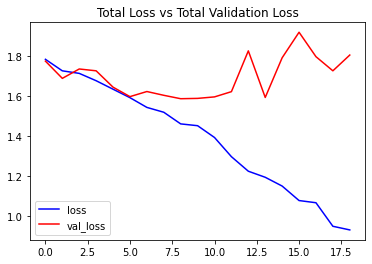

In [17]:
plotMetric(convlstm2d_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

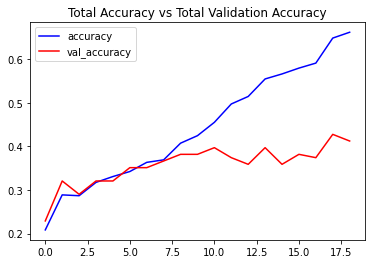

In [18]:
plotMetric(convlstm2d_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [26]:
def createLRCN():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(SELECTED_ACTIONS), activation = 'softmax'))
 
    model.summary()
    return model

In [27]:
lrcn_model= createLRCN()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 30, 75, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 18, 15, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 30, 18, 15, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 18, 15, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 30, 4, 3, 32)    

In [28]:
earlyStoppingCallback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

lrcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

lrcn_model_training = lrcn_model.fit(x = X_train, y = y_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks=[earlyStoppingCallback])

Epoch 1/70
131/131 [==============================] - 41s 291ms/step - loss: 1.7810 - accuracy: 0.2046 - val_loss: 1.7680 - val_accuracy: 0.2748
Epoch 2/70
131/131 [==============================] - 42s 320ms/step - loss: 1.7323 - accuracy: 0.2524 - val_loss: 1.6572 - val_accuracy: 0.2748
Epoch 3/70
131/131 [==============================] - 41s 316ms/step - loss: 1.6535 - accuracy: 0.3002 - val_loss: 1.7465 - val_accuracy: 0.3053
Epoch 4/70
131/131 [==============================] - 45s 340ms/step - loss: 1.6470 - accuracy: 0.2849 - val_loss: 1.6781 - val_accuracy: 0.3130
Epoch 5/70
 21/131 [===>..........................] - ETA: 28s - loss: 1.6258 - accuracy: 0.2976

KeyboardInterrupt: ignored

In [ ]:
model_loss, model_accuracy= lrcn_model.evaluate(X_test, y_test)

In [ ]:
model_file_name= f'lrcn_model__loss_{model_loss}__accuracy_{model_accuracy}.h5'
lrcn_model.save(model_file_name)

In [ ]:
plotMetric(lrcn_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
plotMetric(lrcn_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')